# Simple classification model using Kolmogorov-Arnold Network
This is a simple notebook to demonstrate basic principles of Kolmogorov-Arnold Network model design and traning with highly imbalanced training data. 

(c) Mikko Kursula 2024. MIT License. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
import torch.nn as nn

## Get input data and define the training target

In [2]:
def define_dataset(n_samples):
    """
    Get random numbers in the [-1, 1] range, arrange those to x, y coordinate 
    pairs and define the labels according to the coordinate location. 
    """
    head_radius=0.5
    ear_radius=0.2
    thickness=0.02
    
    x = np.random.rand(n_samples, 2) * 2 - 1
    labels = np.zeros(n_samples)

    head_dist = np.sqrt((x[:, 0] - 0)**2 + (x[:, 1] - 0)**2)
    labels[(head_dist >= head_radius - thickness) & (head_dist <= head_radius + thickness)] = 1

    left_ear_dist = np.sqrt((x[:, 0] + 0.5)**2 + (x[:, 1] - 0.5)**2)
    labels[(left_ear_dist >= ear_radius - thickness) & (left_ear_dist <= ear_radius + thickness)] = 1

    right_ear_dist = np.sqrt((x[:, 0] - 0.5)**2 + (x[:, 1] - 0.5)**2)
    labels[(right_ear_dist >= ear_radius - thickness) & (right_ear_dist <= ear_radius + thickness)] = 1
    
    labels = labels.reshape(-1, 1)
    return x.astype(np.float32), labels.astype(np.float32)
    
input_data, target_data = define_dataset(n_samples=20000)

## Visualize the data

In [3]:
def scatter_plot(input_data, labels, figsize=(10, 8), cmap=None, vmin=0, vmax=1):
    """
    Plot all the points and color those according to the classifications. 
    """
    if cmap is None: 
        colors = [(0, 0, 1), (0, 0.8, 0.8), (1, 1, 0), (1, 0, 0)]  # Blue, Cyan, Yellow, Red
        cmap = LinearSegmentedColormap.from_list("blue_cyan_red", colors)
    
    plt.figure(figsize=figsize)
    plt.axes().set_aspect('equal')
    ax = plt.gca()
    ax.set_facecolor((0, 0, 0))
    plt.scatter(input_data[:, 0], input_data[:, 1], c=labels, alpha=1, s=10, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

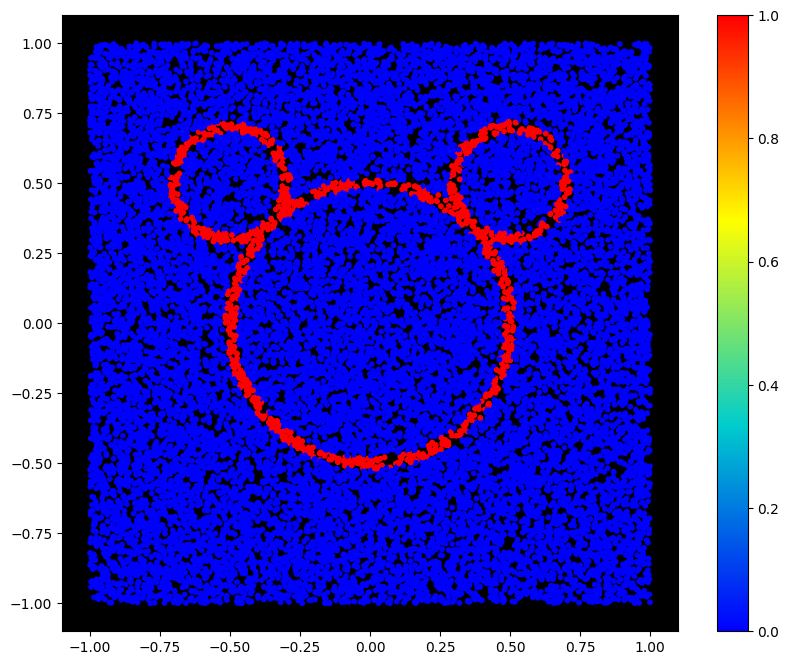

In [4]:
scatter_plot(input_data, target_data)

## Check class balance

In [5]:
n_neg = np.sum(target_data == 0)
n_pos = np.sum(target_data == 1)
print('Class 0 samples : {}'.format(n_neg))
print('Class 1 samples : {}'.format(n_pos))
print('Zero/one class ratio : {:.2f}'.format(n_neg / n_pos))

Class 0 samples : 18853
Class 1 samples : 1147
Zero/one class ratio : 16.44


# KAN model

In [6]:
class VectorizedKANLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_knots=4, x_min=-1.0, x_max=1.0):
        """
        Vectorized Kolmogorov-Arnold Network  Layer with quadratic B-splines per connection.
        All splines share the same knot positions and are processed in a vectorized manner.

        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Number of neurons in the hidden combination layer.
            num_knots (int): Number of knots for each spline. Must be >=3 for quadratic B-splines.
            x_min (float): Minimum x-value for the splines.
            x_max (float): Maximum x-value for the splines.
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        if num_knots < 3:
            raise ValueError("Number of knots must be at least 3 for quadratic B-splines.")

        self.num_knots = num_knots
        self.x_min = x_min
        self.x_max = x_max

        # Fixed knot positions (shared across all splines)
        self.register_buffer('knots', torch.linspace(x_min, x_max, steps=num_knots))  # Shape: (num_knots,)

        # Initialize control points for all splines
        # Shape: (hidden_dim, input_dim, num_knots)
        self.y = nn.Parameter(torch.randn(hidden_dim, input_dim, num_knots) * 0.1)

        # Bias for each hidden neuron
        self.bias = nn.Parameter(torch.zeros(hidden_dim))

    
    def forward(self, x):
        """
        Forward pass for the vectorized KAN layer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            Tensor: Output tensor of shape (batch_size, hidden_dim).
        """
        batch_size = x.size(0)
        device = x.device

        # Clamp x to the spline range
        x_clamped = torch.clamp(x, self.x_min, self.x_max)  # Shape: (batch_size, input_dim)

        # Find the knot indices for each x
        # Shape: (batch_size, input_dim)
        knot_indices = torch.searchsorted(self.knots, x_clamped, right=True) - 1
        knot_indices = torch.clamp(knot_indices, 1, self.num_knots - 2)  # Ensuring valid indices

        # Gather the relevant knot positions for normalization
        t1 = self.knots[knot_indices]        # Shape: (batch_size, input_dim)
        t2 = self.knots[knot_indices + 1]    # Shape: (batch_size, input_dim)

        # Normalize x within the knot span
        t = (x_clamped - t1) / (t2 - t1)     # Shape: (batch_size, input_dim)
        
        # Compute the quadratic B-spline basis functions
        B0 = 0.5 * (1 - t) ** 2               # Shape: (batch_size, input_dim)
        B1 = -t ** 2 + t + 0.5                 # Shape: (batch_size, input_dim)
        B2 = 0.5 * t ** 2                      # Shape: (batch_size, input_dim)

        # Reshape tensors for broadcasting
        # Expand x to (batch_size, 1, input_dim)
        B0 = B0.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)
        B1 = B1.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)
        B2 = B2.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)

        # Prepare indices for gathering y0, y1, y2
        # Shape: (batch_size, 1, input_dim)
        k0 = (knot_indices - 1)
        k1 = knot_indices
        k2 = (knot_indices + 1)

        # Ensure indices are on the correct device and of type long
        k0 = k0.to(device=device, dtype=torch.long)
        k1 = k1.to(device=device, dtype=torch.long)
        k2 = k2.to(device=device, dtype=torch.long)

        # Expand y for gathering
        # y: (hidden_dim, input_dim, num_knots) -> (1, hidden_dim, input_dim, num_knots)
        y_expanded = self.y.unsqueeze(0)  # Shape: (1, hidden_dim, input_dim, num_knots)

        # Expand knot indices to match y's dimensions for gathering
        # Shape: (batch_size, input_dim) -> (batch_size, 1, input_dim)
        k0 = k0.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)
        k1 = k1.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)
        k2 = k2.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)
        
        # Now expand to match the dimension of y_expanded, which is (1, hidden_dim, input_dim, num_knots)
        # The gather operation will work along the last dimension (num_knots), so the index tensors need to match this
        # Expand to (batch_size, hidden_dim, input_dim, 1)
        k0 = k0.expand(-1, self.hidden_dim, -1).unsqueeze(-1)
        k1 = k1.expand(-1, self.hidden_dim, -1).unsqueeze(-1)
        k2 = k2.expand(-1, self.hidden_dim, -1).unsqueeze(-1)
        
        # Expand y for gathering
        # y: (hidden_dim, input_dim, num_knots) -> (batch_size, hidden_dim, input_dim, num_knots)
        # Shape: (batch_size, hidden_dim, input_dim, num_knots)
        y_expanded = self.y.unsqueeze(0).expand(batch_size, -1, -1, -1)  
        
        # Now the gather operations should work without dimension mismatches
        y0 = torch.gather(y_expanded, 3, k0).squeeze(3)  # Shape: (batch_size, hidden_dim, input_dim)
        y1 = torch.gather(y_expanded, 3, k1).squeeze(3)  # Shape: (batch_size, hidden_dim, input_dim)
        y2 = torch.gather(y_expanded, 3, k2).squeeze(3)  # Shape: (batch_size, hidden_dim, input_dim)

        # Compute the spline outputs
        # B0, B1, B2: (batch_size, 1, input_dim)
        # y0, y1, y2: (batch_size, hidden_dim, input_dim)
        # Result: (batch_size, hidden_dim, input_dim)
        spline_outputs = B0 * y0 + B1 * y1 + B2 * y2  # Shape: (batch_size, hidden_dim, input_dim)

        # Sum over the input dimension to get the hidden activations
        # Result: (batch_size, hidden_dim)
        hidden = spline_outputs.sum(dim=2)  # Shape: (batch_size, hidden_dim)

        # Add bias
        hidden = hidden + self.bias  # Shape: (batch_size, hidden_dim)

        return hidden


class KANModel(nn.Module):
    def __init__(self, 
                 input_dim : int, 
                 output_dim : int,
                 hidden_layers : list, 
                 num_knots : int = 4, 
                ):
        """
        Multilayer Kolmogorov-Arnold Network (KAN) model with quadratic B-splines per connection.

        Args:
            input_dim (int): Number of input features.
            output_dim (int): Dimension of the output.
            hidden_layers (list of int): Number of neurons in each hidden KAN layer.
            num_knots (int): Number of knots for each spline. Must be >=3 for quadratic B-splines.
        """
        super().__init__()
        self.layers = nn.ModuleList()

        # Hidden layers
        current_input_dim = input_dim
        for layer_dim in hidden_layers:
            self.layers.append(VectorizedKANLayer(current_input_dim, layer_dim, num_knots=num_knots))
            current_input_dim = layer_dim  # Update input_dim for the next layer

        # Output layer 
        self.layers.append(VectorizedKANLayer(current_input_dim, output_dim, num_knots=num_knots))

    
    def forward(self, x):
        """
        Forward pass for the Vectorized KAN model.

        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            Tensor: Output tensor of shape (batch_size, output_dim).
        """
        for layer in self.layers:
            x = layer(x)  
        return x

## Setup and train the model

In [7]:
# Hyperparameters
input_dim = 2
output_dim = 1
hidden_layers = [10, 10]
num_knots = 7
learning_rate = 0.003
num_epochs = 50      
batch_size = 64

# Setup datasets
dataset = torch.utils.data.TensorDataset(torch.from_numpy(input_data), torch.from_numpy(target_data))
split_ratio = 0.8
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [split_ratio, 1 - split_ratio])

# Create separate DataLoaders for train and test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Setup model 
model = KANModel(
    input_dim=input_dim, 
    output_dim=output_dim,
    hidden_layers=hidden_layers,
    num_knots=num_knots,
)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_loss = []
test_loss = []
for epoch in range(1, num_epochs + 1):
    # Train 
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_func(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * batch_X.size(0)
    epoch_train_loss /= len(train_loader.dataset)
    train_loss.append(epoch_train_loss)

    # Test
    model.eval()
    epoch_test_loss = 0.0
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = loss_func(outputs, batch_y)
        epoch_test_loss += loss.item() * batch_X.size(0)
    epoch_test_loss /= len(test_loader.dataset)
    test_loss.append(epoch_test_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{num_epochs}, train: {epoch_train_loss:.6f}, test: {epoch_train_loss:.6f}")


Epoch 5/50, train: 0.023978, test: 0.023978
Epoch 10/50, train: 0.016941, test: 0.016941
Epoch 15/50, train: 0.014597, test: 0.014597
Epoch 20/50, train: 0.020169, test: 0.020169
Epoch 25/50, train: 0.011569, test: 0.011569
Epoch 30/50, train: 0.009086, test: 0.009086
Epoch 35/50, train: 0.008480, test: 0.008480
Epoch 40/50, train: 0.007614, test: 0.007614
Epoch 45/50, train: 0.007770, test: 0.007770
Epoch 50/50, train: 0.007168, test: 0.007168


## Plot training results

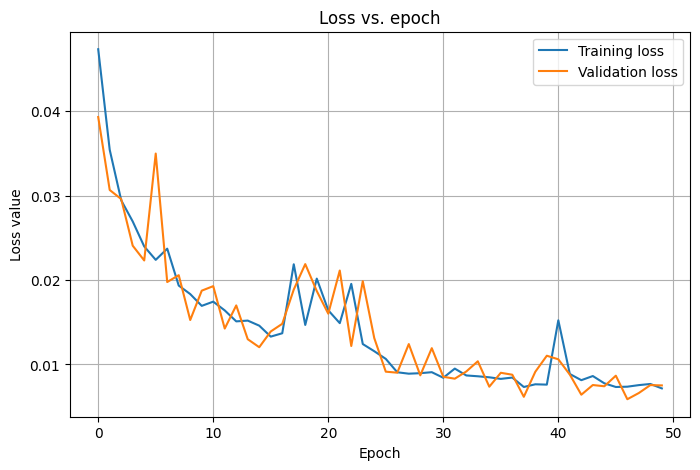

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Validation loss')
plt.title('Loss vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.grid()
plt.show()

## Testing
This demonstrates simple classification quality evaluation and the typical pitfalls in using common metrics such as accuracy.

In [9]:
# Make predictions using new data 
x, y_true = define_dataset(n_samples=20000)
x = torch.from_numpy(x)
y_pred = model(x).detach().numpy()

In [10]:
# Categorize y values to True and False categories. 
class_threshold = 0.5

# Define true labels in boolean values
true = np.zeros(y_true.shape)
mask = y_true >= class_threshold
true[mask] = True
true[~mask] = False

# Predicted boolean values
pred = np.zeros(y_pred.shape)
mask = y_pred >= class_threshold
pred[mask] = True
pred[~mask] = False

# Define true and false positive and negative counts 
TP = np.sum((true == True) & (pred == True))
TN = np.sum((true == False) & (pred == False))
FP = np.sum((true == False) & (pred == True))
FN = np.sum((true == True) & (pred == False))

# Scores
precision = TP / (TP + FP) if ((TP + FP) != 0) else 0
recall = TP / (TP + FN) if ((TP + FN) != 0) else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1_score = 2 * (precision * recall) / (precision + recall) if ((precision + recall) != 0) else 0

print(f'Precision: {precision:.3f}')
print(f'Recall   : {recall:.3f}')
print(f'Accuracy : {accuracy:.3f}')
print(f'F1 score : {f1_score:.3f}')


Precision: 0.933
Recall   : 0.885
Accuracy : 0.990
F1 score : 0.908


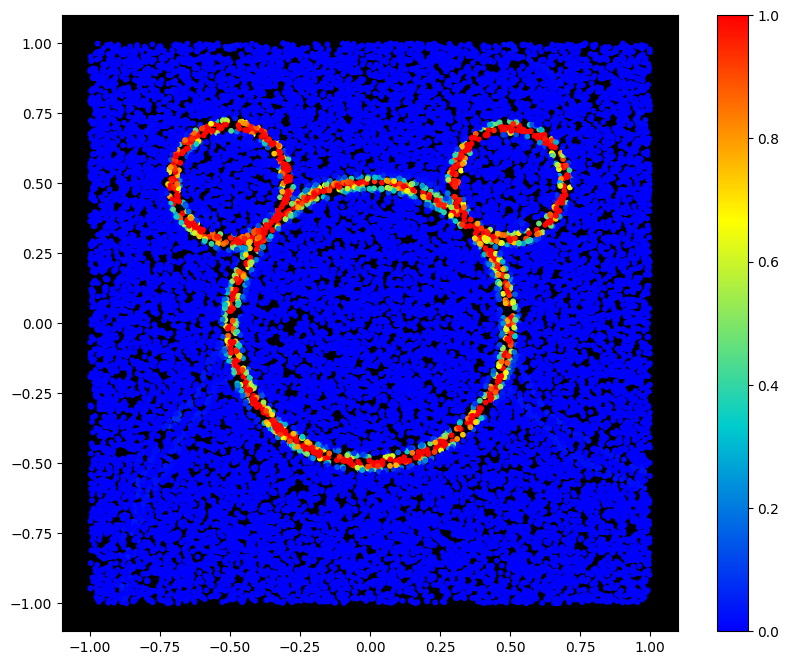

In [11]:
# Plot the prediction results using continuous predicted values. 
# This illustrates the decision boundaries and possible areas of model confusion. 

scatter_plot(x, y_pred)

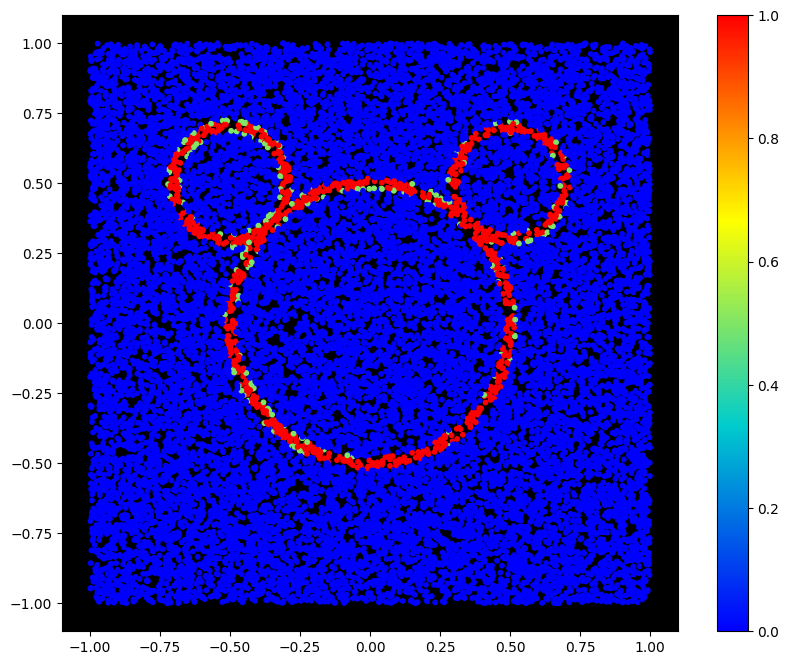

In [12]:
# Same plot as above, but this time with categorized predictions
# Incorrectly categorized samples are shown with value 0.5 (green)
c_val = pred.copy()
mask = pred != true
c_val[mask] = 0.5

scatter_plot(x, c_val)

## Spline visualization 

In [13]:
def visualize_spline_connection(model, layer_index, input_index, output_index):
    """
    Visualizes a specific spline connection in a Kolmogorov-Arnold Network (KAN) model
    using the layer's forward method.

    Args:
        model (KANModel): The KAN model instance.
        layer_index (int): Index of the layer containing the input neuron.
        input_index (int): Index of the input neuron in the specified layer.
        output_index (int): Index of the output neuron in the next layer.

    Raises:
        IndexError: If the specified layer, input, or output indices are out of range.
    """
    # Validate layer index
    if layer_index < 0 or layer_index >= len(model.layers):
        raise IndexError(f"Layer index {layer_index} is out of range. Model has {len(model.layers)} layers.")
    
    layer = model.layers[layer_index]
    
    # Validate input and output indices
    if input_index < 0 or input_index >= layer.input_dim:
        raise IndexError(f"Input index {input_index} is out of range for layer {layer_index} with input_dim {layer.input_dim}.")
    if output_index < 0 or output_index >= layer.hidden_dim:
        raise IndexError(f"Output index {output_index} is out of range for layer {layer_index} with hidden_dim {layer.hidden_dim}.")
    
    # Extract layer parameters
    x_min = layer.x_min
    x_max = layer.x_max
    num_points = 1000  # Number of points for smooth plotting

    # Generate a range of input values for the specified input neuron
    x_values = np.linspace(x_min, x_max, num_points)
    
    # Create input tensor:
    # Initialize all inputs to zero
    # Set the specified input_index to vary across x_values
    input_tensor = torch.zeros(num_points, layer.input_dim)
    input_tensor[:, input_index] = torch.tensor(x_values)
    
    # Ensure the input tensor is on the same device as the model
    input_tensor = input_tensor.to(next(layer.parameters()).device)
    
    # Perform forward pass
    with torch.no_grad():
        layer_output = layer(input_tensor)  # Shape: (num_points, hidden_dim)
    
    # Extract the output for the specified output neuron
    output_values = layer_output[:, output_index].cpu().numpy()
    
    # Extract the bias for the output neuron
    bias = layer.bias[output_index].item()
    
    # Isolate the spline contribution by subtracting the bias
    spline_output = output_values - bias
    
    # Plot the spline
    plt.figure(figsize=(6, 4))
    plt.plot(x_values, spline_output, color='blue')
    
    # Extract control points for the specified connection
    y_j_i = layer.y[output_index, input_index, :].detach().cpu().numpy()  # Shape: (num_knots,)
    knots = layer.knots.detach().cpu().numpy()  # Shape: (num_knots,)
    plt.scatter(knots, y_j_i, color='red', zorder=5)
    
    title = 'B-spline connection and control point visualization'
    title += f'\nLayer {layer_index}: Node {input_index} → Layer {layer_index + 1}: Node {output_index}'
    plt.title(title)
    plt.xlabel('Input x')
    plt.ylabel('Spline Output y(x) - Bias')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


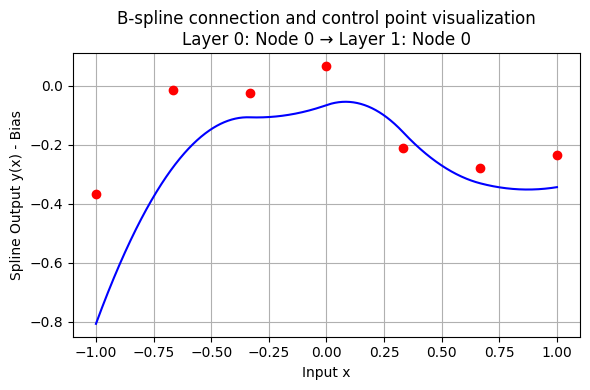

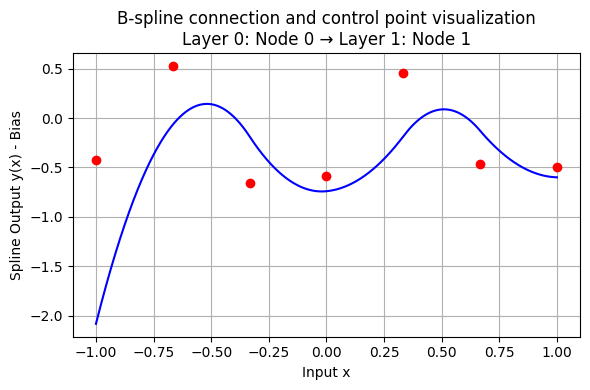

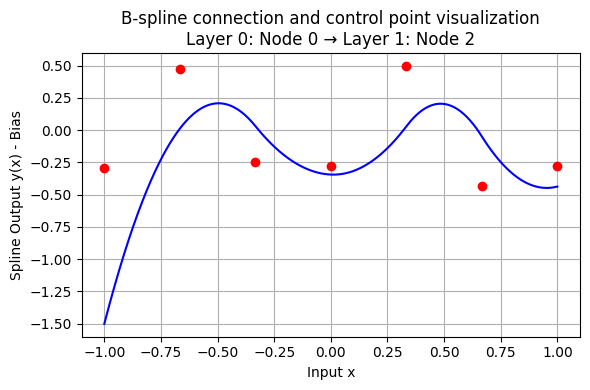

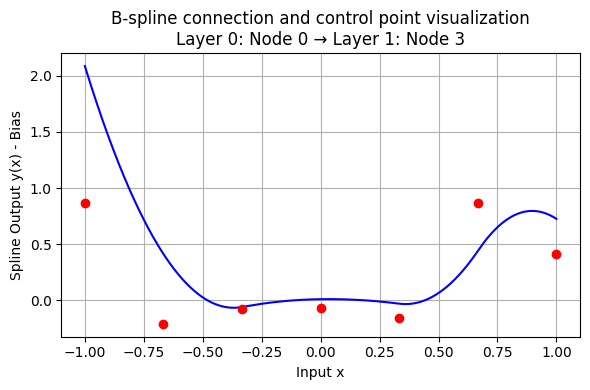

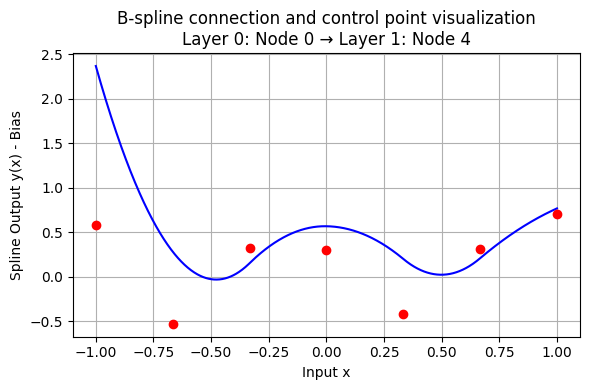

In [14]:
selected_layer = 0
node_a = 0
for i in range(5):
    node_b = i
    visualize_spline_connection(model, selected_layer, node_a, node_b)